In [81]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import numpy as np
import ipdb
import platform
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
opj = os.path.join
deb = ipdb.set_trace

# MRI imports
# -----------
import nibabel as nb
import cortex
from cortex.fmriprep import *
from nipype.interfaces import fsl, freesurfer

# Functions import
# ----------------
from utils import set_pycortex_config_file, draw_cortex_vertex

# Get inputs
# ----------
subject = 'sub-01'
acq = 'acq-2mm'
fit_model = 'gauss'

if fit_model == 'gauss': fit_val = 6
elif fit_model == 'css': fit_val = 7

# Define analysis parameters
# --------------------------
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

In [82]:
# Define folder
# -------------
base_dir = analysis_info['base_dir_local']
deriv_dir = opj(base_dir,'pp_data',subject,fit_model,'deriv')
cortex_dir = "{base_dir}/pp_data/cortex/db/{subject}".format(base_dir = base_dir, subject = subject)
fs_dir = "{base_dir}/deriv_data/fmriprep/freesurfer/".format(base_dir = base_dir)
fmriprep_dir = "{base_dir}/deriv_data/fmriprep/fmriprep/".format(base_dir = base_dir)
bids_dir = "{base_dir}/bids_data/".format(base_dir = base_dir)
xfm_name = "AttendStim_{acq}".format(acq = acq)
xfm_dir = "{cortex_dir}/transforms/{xfm_name}".format(cortex_dir = cortex_dir, xfm_name = xfm_name)

In [83]:
# Set pycortex db and colormaps
# -----------------------------
set_pycortex_config_file(base_dir)

# Add participant to pycortex db
# ------------------------------

if os.path.isdir(cortex_dir) == False:
    print('add subject to pycortex database')

    cortex.freesurfer.import_subj(subject = subject, sname = subject, freesurfer_subject_dir = fs_dir)
    cortex.freesurfer.import_flat(subject = subject, patch='full', freesurfer_subject_dir = fs_dir)

add subject to pycortex database
b'created by mszinte on Tue Oct  1 10:28:07 2019\n'
b'created by mszinte on Tue Oct  1 16:48:09 2019\n'
b'created by mszinte on Tue Oct  1 10:21:43 2019\n'
b'created by mszinte on Tue Oct  1 15:58:58 2019\n'
b'created by mszinte on Tue Oct  1 10:28:07 2019\n'
b'created by mszinte on Tue Oct  1 10:21:43 2019\n'
b'created by mszinte on Tue Oct  1 16:48:09 2019\n'
b'created by mszinte on Tue Oct  1 15:58:58 2019\n'
b'created by mszinte on Tue Oct  1 10:28:22 2019\n'
b'created by mszinte on Tue Oct  1 10:21:58 2019\n'
b'created by mszinte on Tue Oct  1 10:28:07 2019\n'
saving to /Users/martin/disks/meso_S/data/pRFseqTest/pp_data/cortex/db/sub-01/surfaces/flat_lh.gii
b'created by mszinte on Tue Oct  1 10:21:43 2019\n'
saving to /Users/martin/disks/meso_S/data/pRFseqTest/pp_data/cortex/db/sub-01/surfaces/flat_rh.gii


In [ ]:
# Create pycortex xfm
# -------------------
if os.path.isdir(xfm_dir) == False:

    try:os.makedirs(opj(base_dir,'pp_data',subject,'reg'))
    except:pass
    
    # convert T1.mgz to nifti using mriconvert
    t1_mgz_file = "{fs_dir}{subject}/mri/T1.mgz".format(fs_dir = fs_dir, subject = subject)
    t1_file = "{base_dir}/pp_data/{sub}/reg/{sub}_task-AttendStim_{acq}_T1w.nii.gz".format(
                                base_dir = base_dir, sub = subject, acq = acq)
    t1_cmd = freesurfer.MRIConvert(out_type = 'niigz', in_file = t1_mgz_file, out_file = t1_file)
    t1_cmd.run()
    
    data_file  =  "{base_dir}/pp_data/{sub}/func/{sub}_task-AttendStim_{acq}_run-01_fmriprep.nii.gz".format(
                                base_dir = base_dir,
                                sub = subject,
                                acq = acq)

    # get mean file
    mean_file  =  "{base_dir}/pp_data/{sub}/reg/{sub}_task-AttendStim_{acq}_mean.nii.gz".format(
                                base_dir = base_dir, sub = subject, acq = acq)

    mean_cmd = fsl.maths.MeanImage( in_file = data_file, dimension = 'T', out_file = mean_file)
    mean_cmd.run()
    
#     mean_file_img = nb.load(mean_file)
#     mean_file_T_img = nb.Nifti1Image(dataobj = mean_file_img.get_data().transpose((2,1,0)), 
#                                      affine = mean_file_img.affine, 
#                                      header = mean_file_img.header)
#     mean_file_T_img.to_filename(mean_file)
    
    # get reg mat
    reg_cmd = freesurfer.BBRegister(init = 'header', contrast_type = 't2', 
                                    subjects_dir = fs_dir, source_file = mean_file,
                                    subject_id = subject, out_fsl_file = True)
    reg_cmd.run()

    #  create xfm transform
    xfm_file = "{mean_file}_bbreg_{subject}.mat".format(mean_file = mean_file[:-7],subject = subject)
    xfm = cortex.xfm.Transform.from_fsl(xfm = xfm_file, func_nii = mean_file, anat_nii = t1_file)
    xfm.save(subject = subject, name = xfm_name)

In [85]:
# Draw pycortex flatmaps
# ----------------------
print('draw pycortex flatmaps')
cmap_neg_pos = 'RdBu_r'
cmap_polar = 'hsv'
col_offset = 1/14.0
polar_col_steps = [4.0, 8.0, 16.0, 255.0]
cmap_ecc_size = 'Spectral'
cmap_uni = 'Reds'
sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11

draw pycortex flatmaps


In [91]:
for mask_dir in ['all']:

    # Create figure folders
    maps_names = []
    exec('fig_roi_dir_{mask_dir} = opj(base_dir,"pp_data",subject,fit_model,"figs","flatmaps","{mask_dir}")'.format(mask_dir = mask_dir))
    try: exec('os.makedirs(fig_roi_dir_{mask_dir})'.format(mask_dir=mask_dir))
    except: pass

    # Load data
    deriv_mat=[]
    deriv_mat_file = "{deriv_dir}/{mask_dir}/prf_deriv_{acq}_{mask_dir}.nii.gz".format(deriv_dir = deriv_dir,acq = acq, mask_dir = mask_dir)
    img_deriv_mat = nb.load(deriv_mat_file)
    deriv_mat = img_deriv_mat.get_data()

    # R-square
    rsq_data = deriv_mat[...,rsq_idx]
    data = rsq_data


In [92]:
volume = cortex.Volume( data = data.T,
                        cmap = 'Reds',
                        subject = subject,
                        xfmname = xfm_name,
                        vmin = 0,
                        vmax = 1)

Generating a flatmap cache
Generating a flatmap cache
** (inkscape-bin:21393): WARNING **: Échec de la détection automatique du format. Le fichier est ouvert en tant que SVG.


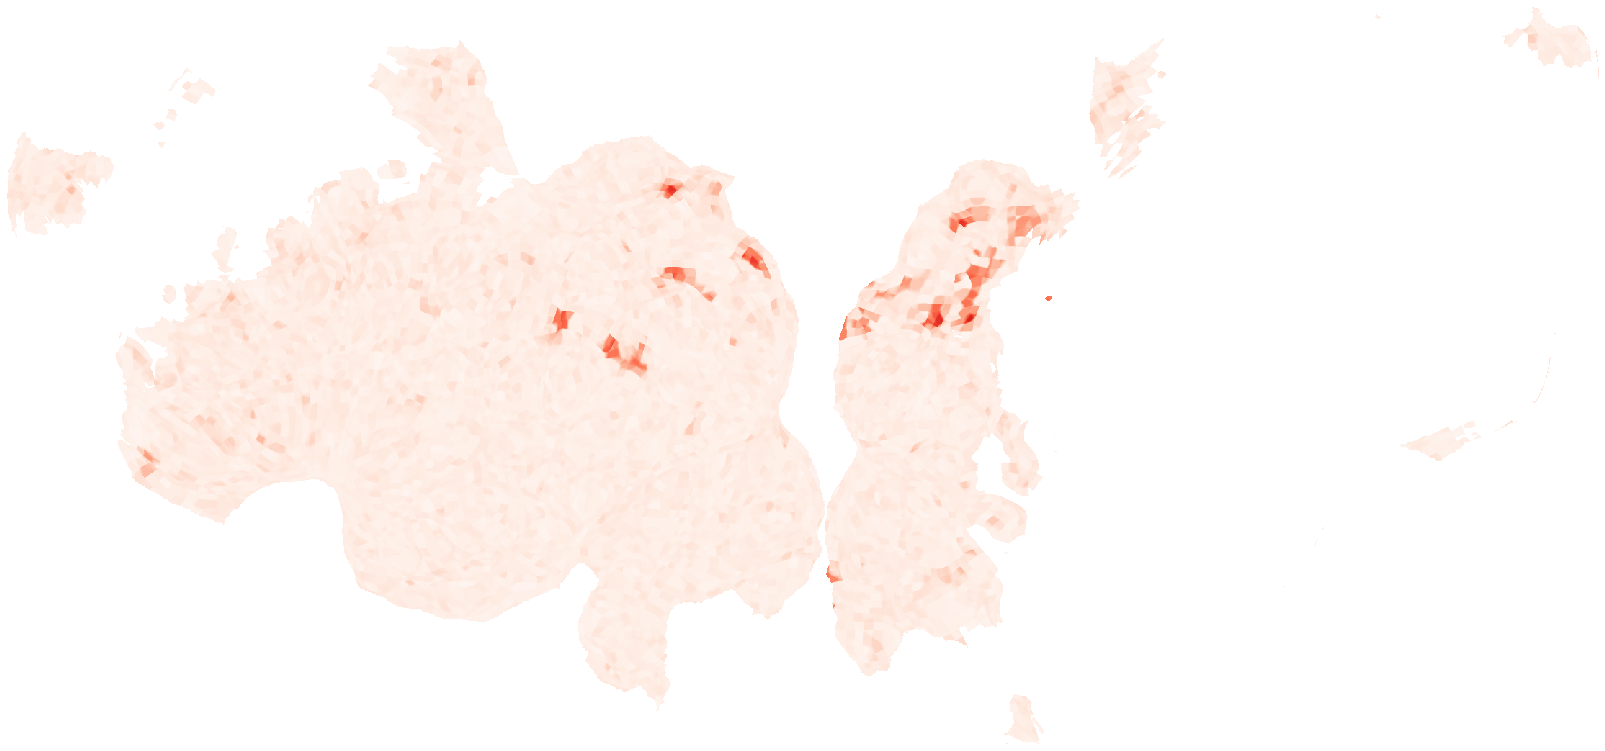

In [93]:
quickshow = cortex.quickshow( braindata = volume,with_colorbar = False,)

# # Discrete color bars
# # -------------------
# colorbar_location= [0.9, 0.05, 0.03, 0.25]
# cmaplist = [colmap(i) for i in range(colmap.N)]

# # define the bins and normalize
# bounds = np.linspace(vmin, vmax, cmap_steps + 1)
# bounds_label = np.linspace(vmin, vmax, 3)
# norm = matplotlib.colors.BoundaryNorm(bounds, colmap.N)

# cbar_axis = quickshow.add_axes(colorbar_location)
# cb = matplotlib.colorbar.ColorbarBase(cbar_axis,cmap = colmap,norm = norm,ticks = bounds_label,boundaries = bounds)
# # plt.savefig("{imdir}flat_svg.pdf".format(imdir = img_dir),facecolor="w")